In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder#
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Loading our MNIST dataset
data = load_digits()
X = data['data']
y = data['target']

# one-hot encoding
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1)).toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X/16, y, test_size=0.3)

In [3]:
# Function to visualize a specific data point at a given index
def data_visualization_index(data, target, index):
    # Create a new figure for the plot with an 8x8-inch size
    plt.figure(figsize=(8, 8))
    
    # Display the image of the data point at the specified index, reshaped to 8x8, in grayscale
    plt.imshow(data[index].reshape(8, 8), cmap='gray')
    
    # Set the title of the plot to the corresponding target value
    plt.title(target[index])
    
    # Turn off the axis labels and ticks for a cleaner visualization
    plt.axis('off')
    
    # Show the plot on the screen
    plt.show() 

# Function to visualize the entire dataset as a single image
def data_visualization(data, target):
    # Create a new figure for the plot with an 8x8-inch size
    plt.figure(figsize=(8, 8))
    
    # Display the entire dataset as a single image, reshaped to 8x8, in grayscale
    plt.imshow(data.reshape(8, 8), cmap='gray')
    
    # Set the title of the plot to the target label (assuming it's a single label for the entire dataset)
    plt.title(target)
    
    # Turn off the axis labels and ticks for a cleaner visualization
    plt.axis('off')
    
    # Show the plot on the screen
    plt.show()

In [4]:
def data_generator(input_data, target_data, minibatch_size):
    # Get the total number of samples in the dataset
    num_samples = len(input_data)
    
    # Create an array of indices corresponding to the samples
    indices = np.arange(num_samples)
    # Shuffle the indices to randomize the order of samples
    np.random.shuffle(indices)

    # Iterate over the shuffled indices to yield mini-batches
    for start_idx in range(0, num_samples - minibatch_size + 1, minibatch_size):
        # Select a subset of indices for the current mini-batch
        excerpt = indices[start_idx:start_idx + minibatch_size]
        
        # Yield the corresponding input and target data for the mini-batch
        yield input_data[excerpt], target_data[excerpt]

In [5]:
# Sigmoid activation function class
class Sigmoid:
    def __init__(self):
        pass

    def call(self, z):
        try:
            # Calculate the sigmoid activation for a single value or array
            result = 1. / (1. + np.exp(-z))
        except:
            result = []
            # Iterate through each element in the input array and calculate sigmoid
            for y in z:
                for x in y:
                    if x >= 0:
                        result.append(1. / (1. + np.exp(-x)))
                    else:
                        result.append(np.exp(x) / (1. + np.exp(x)))
            result = np.array(result).reshape(z.shape)
        return result

    def gradient(self, x):
        # Calculate the gradient of the sigmoid function for a single value or array
        sigmoid_x = self.call(x)
        gradient_x = sigmoid_x * (1 - sigmoid_x)
        return gradient_x

In [6]:
# Cross-Entropy Loss function class
class CrossEntropyLoss:
    def __init__(self):
        self.probs = None  # Stores the predicted probabilities
        self.targets = None  # Stores the true target values

    def forward(self, prediction, true_target):
        self.probs = prediction.T  # Transpose the prediction to match the shape of the target
        self.targets = true_target
        epsilon = 1e-15  # Small constant to avoid taking the log of zero

        # Clip the predicted probabilities to prevent numerical instability
        prediction = np.clip(prediction, epsilon, 1 - epsilon)

        # Calculate the cross-entropy loss
        loss = -np.sum(self.targets * np.log(self.probs + epsilon))

        # Normalize the loss by the number of samples (common practice, but commented out in this implementation)
        # loss /= self.targets.shape[0]

        return loss

    def backward(self, probs, targets):
        # Calculate the gradient of the cross-entropy loss
        d_loss = probs - targets

        return d_loss


In [7]:
# Softmax activation function class
class Softmax:
    def __init__(self):
        pass

    def call(self, x):
        # Calculate the softmax activation for a given array 'x'
        exp_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
        return exp_x / exp_x.sum(axis=-1, keepdims=True)

    def gradient(self, x):
        # The gradient of the softmax function is the same as the softmax probabilities
        probabilities = self.call(x)
        return probabilities


In [8]:
# Import the necessary library for mathematical operations
import numpy as np

# MLP Layer class
class MLP_Layer:
    def __init__(self, n_neurons, activation_function, index):
        # Initialize the MLP layer with the number of neurons, activation function, and index.
        self.neurons = n_neurons  # Number of neurons in the layer
        self.activation_function = activation_function  # Activation function to be used
        self.index = index  # Index of the layer
        self.activation = 0  # Defines the output of the layer after running through the activation function
        self.preactivation = 0  # Defines the input of the layer before running through the activation function

    def init_weight(self, inputs, neurons):
        # Initialize the weights and bias for the layer.
        self.weights = np.random.normal(loc=0.0, scale=10, size=(neurons, inputs))
        self.bias = np.zeros((neurons, 1))

    def Neuron_activation(self, inputs):
        # Compute the activation of the layer's neurons.
        try:
            self.preactivation = np.dot(self.weights, inputs) + self.bias.ravel()
        except:
            self.preactivation = np.dot(self.weights, inputs) + self.bias
        self.activation = self.activation_function.call(self.preactivation)
        return self.activation

    def activation_gradient(self):
        # Calculate the gradient of the activation function for backpropagation.
        return self.activation_function.gradient(self.activation)


In [9]:
# Define a function for generating data batches
def data_generator(inputs, targets, batch_size):
    for i in range(0, len(inputs), batch_size):
        yield (inputs[i:i + batch_size], targets[i:i + batch_size])

# MLP_print class
class MLP_print:
    def __init__(self, shapes, activation_functions, lossFunction):
        # Initialize the MLP with the provided shapes, activation functions, and loss function.
        self.shape = shapes
        self.activation_functions = activation_functions
        self.layers = list()  # List to store MLP layers
        self.loss = lossFunction  # Loss function for training
        self.losses = list()  # List to store loss values during training
        self.accuracy = 0  # Initialize accuracy variable
        self.accuracies = list()  # List to store accuracy values during training

        j = 0
        # Create MLP layers based on the given shapes and activation functions
        for shape in shapes:
            self.layers.append(MLP_Layer(shape, activation_functions[j], j))
            j += 1

        # Initialize weights and biases for each layer
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].init_weight(X.shape[1], self.layers[i].neurons)
            else:
                self.layers[i].init_weight(self.layers[i - 1].neurons, self.layers[i].neurons)

    def compute_loss(self, result, targets):
        # Compute the loss using the provided loss function
        loss = self.loss.forward(result, targets)
        return loss

    def backward(self, inputs, targets):
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]

        # Calculate the error in the output layer using the loss function
        error_o = self.loss.backward(self.layers[-1].preactivation, targets.T)

        # Iterate through the layers in reverse order to calculate gradients
        for i in reversed(range(len(self.layers) - 1)):
            # Calculate the error for the current layer
            error_i = np.multiply(self.layers[i + 1].weights.T.dot(error_o), self.layers[i].activation_function.gradient(self.layers[i].preactivation))
        
            # Calculate the weight gradients for the current layer
            delta_w[i + 1] = error_o.dot(self.layers[i].activation.T) / len(targets)
        
            # Calculate the bias gradients for the current layer
            delta_b[i + 1] = np.sum(error_o, axis=1, keepdims=True) / len(targets)
        
            # Update the error for the next layer in the iteration
            error_o = error_i

        # Calculate the gradients for the input layer
        try:
            delta_w[0] = error_o.dot(inputs) / len(targets)
            delta_b[0] = np.sum(error_o, axis=1, keepdims=True) / len(targets)
        except:
            delta_w[0] = error_o.dot(inputs.T)
            delta_b[0] = np.sum(error_o, axis=1, keepdims=True) / len(targets)

        return delta_w, delta_b

    def calculate_accuracy(self, results, targets):
        accuracy = 0
        for index, result in enumerate(results):
            index_of_max_result = np.argmax(result)
            index_of_max_target = np.argmax(targets[index])
            if(index_of_max_result == index_of_max_target):
                accuracy += 1

        return accuracy/len(targets)

    def update_weights_and_biases(self, delta_w, delta_b, learning_rate):
        for i in range(len(self.layers)):
            self.layers[i].weights -= learning_rate * delta_w[i]
            self.layers[i].bias -= learning_rate * delta_b[i]

    def train(self, inputs, targets, learning_rate, epochs, batch_size):
        # Train the MLP with the given inputs and targets
        for epoch in range(epochs):
            batches = data_generator(inputs, targets, batch_size)
            for batch in batches:
                batch_x, batch_y = batch
                result = self.predict(batch_x)
                delta_w, delta_b = self.backward(batch_x, batch_y)
                self.update_weights_and_biases(delta_w, delta_b, learning_rate)
                self.accuracy += self.calculate_accuracy(result.T, batch_y)
            
            # Calculate and store the average accuracy for each batch
            self.accuracy = self.accuracy/batch_size
            self.accuracies.append(self.accuracy)

            # Store the loss for this epoch
            self.losses.append(self.compute_loss(result, batch_y))

    def predict(self, X):
        # Make predictions using the provided input data
        a = X.T
        for layer in self.layers:
            a = layer.Neuron_activation(a)
        return a


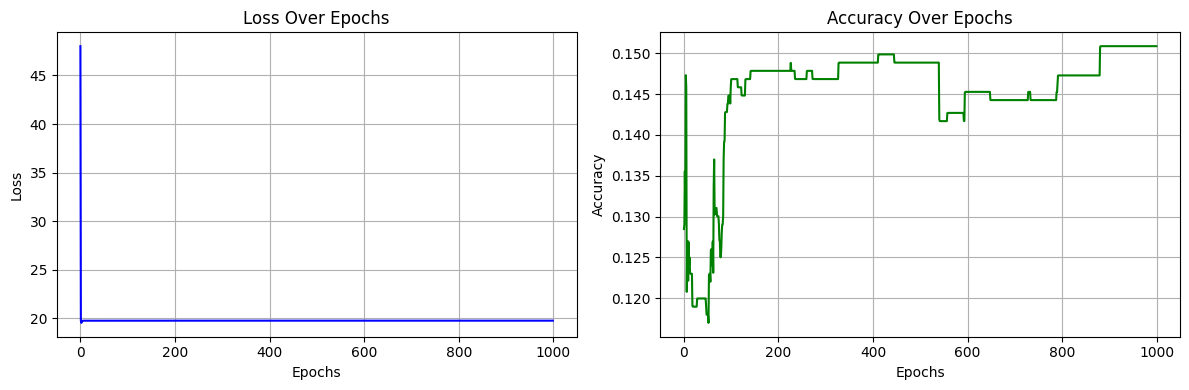

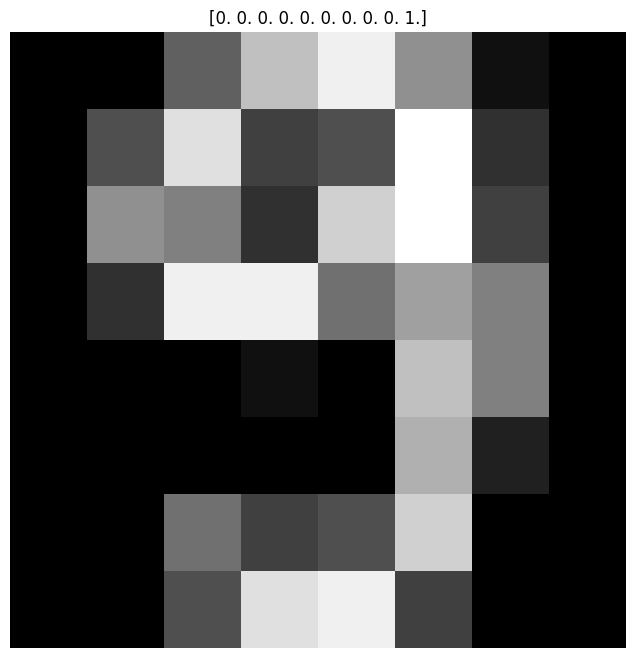

[0.09748536 0.09947188 0.10018762 0.10214838 0.10107307 0.09987506
 0.10235718 0.10209233 0.09832157 0.09698757]


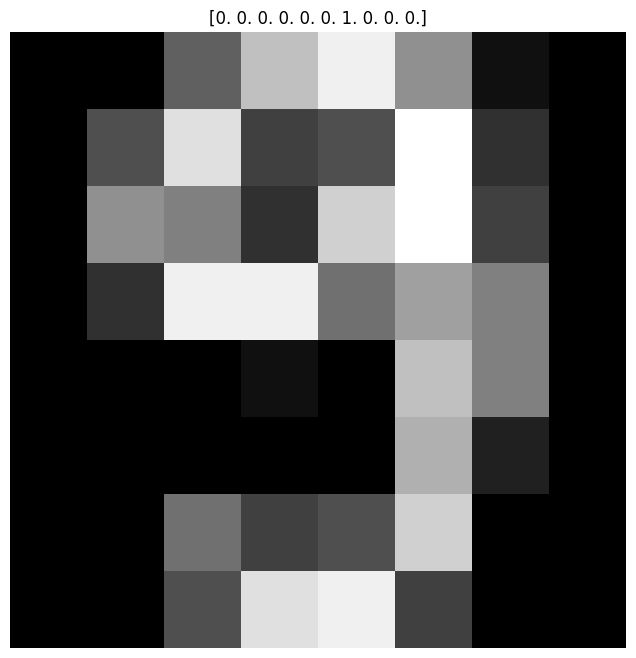

In [10]:
# Define the model and its architecture
model = MLP_print([64,64,64,32, 10], [Sigmoid(), Sigmoid(),Sigmoid(), Sigmoid(), Softmax()], CrossEntropyLoss())

epoch_numbers = 1000

# Train the model
model.train(X_train, y_train, 0.01, epoch_numbers, 32)

# Plot the loss curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
ax1.plot(model.losses, label='Loss', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Over Epochs')
ax1.grid(True)

# Plot Accuracy
ax2.plot(model.accuracies, label='Accuracy', color='green')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Over Epochs')
ax2.grid(True)

plt.tight_layout()  # Ensures that the plots don't overlap

plt.show()

data_visualization_index(X_test, y_test, 0)
temp = model.predict(X_test[0])
print(temp)

#clearer data visualization
index_of_max = np.argmax(temp)

result = np.zeros_like(temp)

result[index_of_max] = 1


data_visualization(X_test[0], result)

In [40]:
#
# X- or function
#

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Create an instance of the MLP class
shape = [2, 2, 1] # Define the network architecture
activation_functions = [Sigmoid(),Sigmoid(), Sigmoid()]
lossFunction = CrossEntropyLoss()
mlp = MLP_print(shape, activation_functions, lossFunction)

# Train the MLP on the dataset
learning_rate = 0.1
epochs = 10000
batch_size = 2
mlp.train(X, y, learning_rate, epochs, batch_size)

# Make predictions
#
for i in range(len(X)):
    predictions = mlp.predict(X[i])
    print("input: ", X[i])
    print("Predictions:")
    print(predictions)

input:  [0 0]
Predictions:
[0.9077743]
input:  [0 1]
Predictions:
[0.89988388]
input:  [1 0]
Predictions:
[0.90860649]
input:  [1 1]
Predictions:
[0.81665783]
